## Congestion Statge Estimator (CSE) Training

__1. Training Data:__

    - Data collection: Data is collected using the RL training scripts but horizon is kept at 20 i.e., all vehicles inluding RL behave as IDM.

    - The data is collected at initial configuration of vehicles equally spaced, for for a brief time there will be stable conditions. However, for variation, the density is changed from 70 to 150 veh/km.

    - 800 simulation runs are performed each with a warmup time of 2500 and horizon of 0. This was based on the observation that test accuracy gets better with more data.
    
__2. Neural Network configuration:__

    - Same neural network may have to be scaled to numerous densities
    
__3. Data Processing:__

    - The collected data mostly contains non-transition data.
    - It is filtered and made equally representative of transition and non-transition (50% each).
    - Further, the data is also made equally representative of the 5 (out of  6) class labels.
    - The sixth class, is discussed below.
    
__Additional Notes:__

    - Essentially, the CSC predicts if the RL vehicle were IDM, then what would be the expected traffic state 10-timesteps into the future.

__Important: he No vehicles in front case.__

- It does not make much sense to have "no vehicles in front" to have a transition 
- Based on the information that at present timestep there are no vehicles in front, you cannot predict the future
- The control action is also deterministic in this case (accelerate to reach speed limit)
- So, generate some synthetic data to represent this case

- density 70 veh/km means 22000/312 i.e., length 312 # Nothing but Free Flow
- density 80 veh/km means 22000/275 i.e., length 275
- density 90 veh/km means 22000/242 i.e., length 242
- density 100 veh/km means 22000/200 i.e., length 220 # Everything
- density 110 veh/km means 22000/200 i.e., length 200
- density 120 veh/km means 22000/183 i.e., length 183
- density 130 veh/km means 22000/168 i.e., length 168
- density 140 veh/km means 22000/157 i.e., length 157 # Nothing but Forming, Undefined, Congestion



In [1]:
import os
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
folders = os.listdir('./csc_data')

npy_files = []
for folder in folders: 
    
    # filter to ignore files
    if ".npy" not in folder: 
        npy_files_this_folder = [f'./csc_data/{folder}/' + file for file in os.listdir(f'./csc_data/{folder}') if file.endswith('.npy')]
        print(f"Folder: {folder}, npy_files_this_folder: {len(npy_files_this_folder)}\n")
        npy_files.extend(npy_files_this_folder)

print(f"Total npy_files: {len(npy_files)}")
print(f"First 2 files: {npy_files[:2]}")

Folder: length_157, npy_files_this_folder: 100

Folder: length_168, npy_files_this_folder: 100

Folder: length_183, npy_files_this_folder: 100

Folder: length_201, npy_files_this_folder: 100

Folder: length_221, npy_files_this_folder: 100

Folder: length_242, npy_files_this_folder: 100

Folder: length_275, npy_files_this_folder: 100

Folder: length_312, npy_files_this_folder: 100

Total npy_files: 800
First 2 files: ['./csc_data/length_157/csc_data_2024-02-07-08:14:41.npy', './csc_data/length_157/csc_data_2024-02-07-08:15:00.npy']


In [4]:
all_data = []
for file in npy_files: 
    data = np.load(file, allow_pickle=True)
    all_data.extend(data)

all_data = np.array(all_data)
print(f"all_data.shape: {all_data.shape}, each data point shape: {all_data[0].shape}")
print(f"Sample data: {all_data[0]}") 

# [:,0] is timesteps
# [:,1] is labels
# [:,2] is observations

print(f"first 5 labels: {all_data[:5,1]}") #all_data[:,1][0:5]

all_data.shape: (2800000, 3), each data point shape: (3,)
Sample data: [0 1
 array([[ 0.        ,  0.        ],
       [ 0.29345455,  0.        ],
       [ 0.43618182,  0.        ],
       [ 0.57890909,  0.        ],
       [ 0.72163636,  0.        ],
       [ 0.86436364,  0.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ]])]
first 5 labels: [1 3 3 3 3]


In [5]:
# TIME_WINDOW
TIMESTEP_OFFSET = 10

X = all_data[:, 2] # Observations
y = all_data[:, 1] # TSE labels

print(f"Before offset, X: {X.shape}, y:{y.shape}")

# Go from 0 to (last - TIME_OFFSET)
X = X[0: X.shape[0]-TIMESTEP_OFFSET]

# Go from 0 to (last - TIME_OFFSET)
y_current = y[0: y.shape[0]-TIMESTEP_OFFSET]

# Go from 10 to last
y_future = y[TIMESTEP_OFFSET:]
      
print(f"After offset, X: {X.shape}, y_current:{y_current.shape}, y_future:{y_future.shape}\n")

Before offset, X: (2800000,), y:(2800000,)
After offset, X: (2799990,), y_current:(2799990,), y_future:(2799990,)



In [6]:
labels = [0, 1, 2, 3, 4, 5]
# 0 = Leaving, 1 = Forming, 2 = Free Flow, 3 = Congested, 4 undefined, 5 No vehicle in front
label_meanings = ["Leaving", "Forming", "Free Flow", "Congested", "undefined", "No vehicle in front"]

def display_counts(indices, labels):
    
    num_non_transition = sum(len(indices['non-transition'][label]) for label in labels)
    num_transition = sum(len(indices['transition'][label]) for label in labels)

    print(f'Number of non-transitions: {num_non_transition}')
    print(f'Number of transitions: {num_transition}')
    print(f"In percentage Transitions are: {round(100*(num_transition/num_non_transition),2)}%\n")

    # Count the occurrences of each label
    print(f'Non-transition ({num_non_transition}) counts by label:')
    for label in sorted(labels):
        this_count = len(indices['non-transition'][label])
        print(f'\t{label_meanings[label]}: {this_count}, percentage: {round(100*(this_count/num_non_transition),2)}%')

    print(f'\nTransition ({num_transition}) counts by label:')
    for label in sorted(labels):
        this_count = len(indices['transition'][label])
        print(f'\t{label_meanings[label]}: {this_count}, percentage: {round(100*(this_count/num_transition),2)}%')

In [7]:
# Two objectives:
# Transition and non-transition data must be balanced
# The 6 (5 in actual) labels must be balanced
                  
indices = {'transition': {key: [] for key in labels},
           'non-transition': {key: [] for key in labels}}

# If y_future and y_current have same label, its non-transition data
# If they have different labels, its transition data
for i, (current, future) in enumerate(zip(y_current, y_future)):
    # non-transition
    if current == future:  
        indices['non-transition'][current].append(i)
    # transition
    else:  
        indices['transition'][future].append(i)

display_counts(indices, labels)

# Perform selection
# Whichever among all (transition and non-trainsition) has the lowest counts, pick everything to be that number
actual_labels = [0, 1, 2, 3, 4] # Exclude No vehicle in front for the next couple of steps

lowest_transition = min(len(indices['transition'][label]) for label in actual_labels)
lowest_non_transition = min(len(indices['non-transition'][label]) for label in actual_labels)
lowest = min(lowest_transition, lowest_non_transition)

print(f"\nLowest: {lowest} data points\n")

# select randomly
selected_indices = {'transition': {key: [] for key in actual_labels},
                    'non-transition': {key: [] for key in actual_labels}}

for kind in ['transition', 'non-transition']:
    for label in actual_labels:
        if indices[kind][label]:
            # Randomly select and add
            selected_indices[kind][label] = random.sample(indices[kind][label], lowest) 

display_counts(selected_indices, actual_labels)

Number of non-transitions: 2428708
Number of transitions: 371282
In percentage Transitions are: 15.29%

Non-transition (2428708) counts by label:
	Leaving: 253123, percentage: 10.42%
	Forming: 312872, percentage: 12.88%
	Free Flow: 593528, percentage: 24.44%
	Congested: 532413, percentage: 21.92%
	undefined: 714011, percentage: 29.4%
	No vehicle in front: 22761, percentage: 0.94%

Transition (371282) counts by label:
	Leaving: 51401, percentage: 13.84%
	Forming: 73510, percentage: 19.8%
	Free Flow: 45394, percentage: 12.23%
	Congested: 68067, percentage: 18.33%
	undefined: 127086, percentage: 34.23%
	No vehicle in front: 5824, percentage: 1.57%

Lowest: 45394 data points

Number of non-transitions: 226970
Number of transitions: 226970
In percentage Transitions are: 100.0%

Non-transition (226970) counts by label:
	Leaving: 45394, percentage: 20.0%
	Forming: 45394, percentage: 20.0%
	Free Flow: 45394, percentage: 20.0%
	Congested: 45394, percentage: 20.0%
	undefined: 45394, percentage: 

In [8]:
# Generate the same number (as lowest) of synthetic data for No vehicles in front
# The first vehicle is RL (itself) will have some data

no_veh_data = np.full((lowest, 20), -1.0)
for i in range(lowest):
    # Generate two random numbers between 0 and 1 and fill
    random_numbers = np.random.rand(2)
    no_veh_data[i, :2] = random_numbers
    
no_veh_labels = np.full((lowest,), 5)
print(no_veh_data.shape, no_veh_labels.shape)
print(no_veh_data[100])


(45394, 20) (45394,)
[ 0.64203165  0.08413996 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.        ]


In [9]:
# Select the corresponsing observations as well
X_dataset = []
y_dataset = []

# add real data
for kind in ['transition', 'non-transition']:
    for label in actual_labels:
        for index in selected_indices[kind][label]:
            X_dataset.append(X[index].flatten())
            y_dataset.append(y_future[index])
    
X_dataset = np.array(X_dataset)
y_dataset = np.array(y_dataset)

#add synthethic data. No need to add data.
X_dataset = np.append(X_dataset, no_veh_data, axis=0)
y_dataset = np.append(y_dataset, no_veh_labels, axis=0)

print(X_dataset.shape, y_dataset.shape)

# Validation that the data operation was correctly done
# This works, do not remove
# Select a few indices from here
# for i in actual_labels:
#     print(selected_indices['non-transition'][i][0:2])
#     print(selected_indices['transition'][i][0:2])
# random_indices = [271567, 7646, 199950, 144989]

# for i in random_indices:
#     print(f"\n\n{i}")
#     data =X[i].flatten()
#     print(f"Observation:{data, data.shape}")
#     print(f"Future Label:\t{y_future[i]}")
    
#     # Find the index of 'data' in 'X_dataset'
#     match_index = None
#     for j, x in enumerate(X_dataset):
#         if np.array_equal(x, data):
#             match_index = j
#             break
#     print(f"Match Index in X_dataset: {match_index}")
#     print(f"Found in Dataset X: {X_dataset[match_index]}\nWith Label: {y_dataset[match_index]}\n")
# X_dataset.shape

(499334, 20) (499334,)


/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


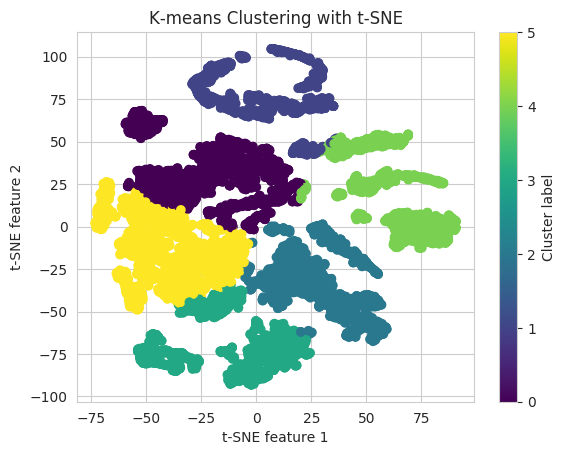

In [10]:
# Visulaization of the observations (position, velocity), cluster of the 5 categories

# Reshape each (10, 2) array into a 20-element vector
X_flattened = X_dataset[0:10000] #Using just a small subset

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_flattened) # if t-SNE is slow; only use a subset

# Apply K-means clustering
kmeans = KMeans(n_clusters= 6, random_state=42)
kmeans.fit(X_reduced)

# Get the cluster assignments for each data point
labels = kmeans.labels_

# Plot the data, colored by cluster assignment
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.title('K-means Clustering with t-SNE')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar(label='Cluster label')
plt.show()

In [11]:
# # split into train, val, and test (70%, 20%, 10%)
# X_train, X_temp, y_train, y_temp = train_test_split(X_dataset, y_dataset, test_size=0.3, random_state=SEED)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=SEED)

# # Printing the shapes of the resulting datasets
# print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
# print(f"Test set: X_test: {X_test.shape}, y_val: {y_test.shape}")

# Considering we have small amount of data, split into train, val=test (85%, 15%)
X_train, X_val, y_train, y_val = train_test_split(X_dataset, y_dataset, test_size=0.15, random_state=SEED, stratify=y_dataset)
X_test = X_val
y_test = y_val

# Printing the shapes of the resulting datasets
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_val: {y_test.shape}")

Training set: X_train: (424433, 20), y_train: (424433,)
Validation set: X_val: (74901, 20), y_val: (74901,)
Test set: X_test: (74901, 20), y_val: (74901,)


In [12]:
# PT helpers
class TrafficDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TSE_Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TSE_Net, self).__init__() 
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(16, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [13]:
def train(net, train_loader, criterion, optimizer, print_every):
    net.train() 
    running_loss = 0.0
    track_running_loss = []
    for i, bdata in enumerate(train_loader, 0):
        inputs, labels = bdata
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % print_every == print_every - 1:
            running_loss = running_loss / print_every
            track_running_loss.append(running_loss)
            #print(f"Training - Batch: {i+1}, Loss: {running_loss:.4f}")
            running_loss = 0.0
            
    return track_running_loss 

def validate(net, val_loader, criterion):
    net.eval()  
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_outputs = net(val_inputs)
            val_batch_loss = criterion(val_outputs, val_labels)
            val_loss += val_batch_loss.item()

            # accuracy
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return val_loss

In [14]:
input_size = X_train.shape[1]  # 20
num_classes = len(np.unique(y_dataset))  # 6
net = TSE_Net(input_size, num_classes)

n_epochs = 50
batch_size = 32
print_every = 50

print(f"The model has {count_parameters(net):} trainable parameters")
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(net.parameters(), lr=0.01)

train_data = TrafficDataset(torch.tensor(X_train, dtype=torch.float32), 
                             torch.tensor(y_train.astype(int), dtype=torch.long))

val_data = TrafficDataset(torch.tensor(X_val, dtype=torch.float32), 
                           torch.tensor(y_val.astype(int), dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
train_loss_values = []
epoch_train_loss_values = []
val_loss_values = []

for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}", end = "\t")
    track_running_loss = train(net, train_loader, criterion, optimizer, print_every)
    val_loss = validate(net, val_loader, criterion)
    
    val_loss_values.append(val_loss)
    train_loss_values.extend(track_running_loss)
    epoch_train_loss_values.append(np.mean(track_running_loss))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        
        save_path = './saved_models/'
        os.makedirs(save_path, exist_ok=True)
        torch.save(net.state_dict(), os.path.join(save_path, 'ring_best_csc_model.pt'))
        
        print("###### New model saved ######")

The model has 1302 trainable parameters
Epoch: 1	Validation - Loss: 0.2225, Accuracy: 91.72%
###### New model saved ######
Epoch: 2	Validation - Loss: 0.2504, Accuracy: 91.71%
Epoch: 3	Validation - Loss: 0.2177, Accuracy: 91.85%
###### New model saved ######
Epoch: 4	Validation - Loss: 0.1741, Accuracy: 93.73%
###### New model saved ######
Epoch: 5	Validation - Loss: 0.1691, Accuracy: 94.26%
###### New model saved ######
Epoch: 6	Validation - Loss: 0.1735, Accuracy: 93.87%
Epoch: 7	Validation - Loss: 0.1604, Accuracy: 94.48%
###### New model saved ######
Epoch: 8	Validation - Loss: 0.1858, Accuracy: 93.50%
Epoch: 9	Validation - Loss: 0.1872, Accuracy: 93.67%
Epoch: 10	Validation - Loss: 0.1617, Accuracy: 94.17%
Epoch: 11	Validation - Loss: 0.1577, Accuracy: 94.26%
###### New model saved ######
Epoch: 12	Validation - Loss: 0.1788, Accuracy: 93.75%
Epoch: 13	Validation - Loss: 0.1811, Accuracy: 93.47%
Epoch: 14	Validation - Loss: 0.1648, Accuracy: 94.48%
Epoch: 15	Validation - Loss: 0.14

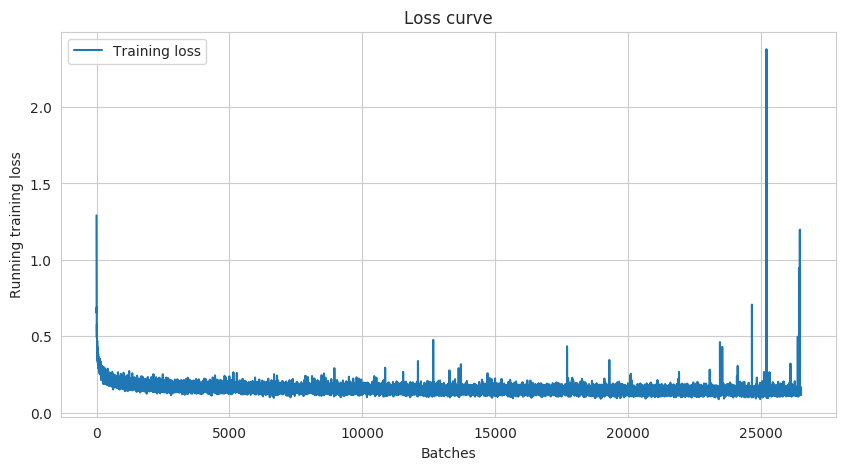

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label = "Training loss")
plt.title('Loss curve')
plt.xlabel('Batches')
plt.ylabel('Running training loss')
plt.legend()

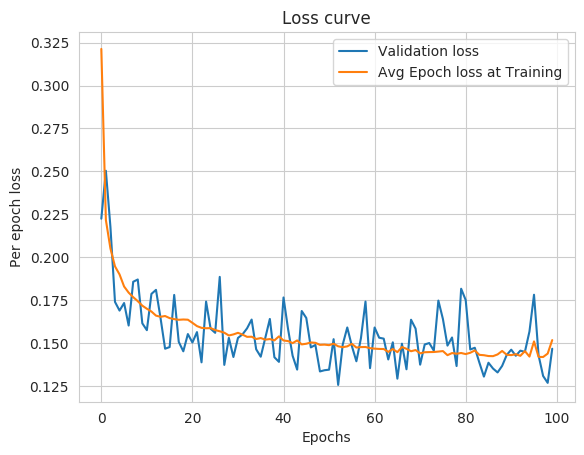

In [16]:
plt.plot(val_loss_values, label="Validation loss")
plt.plot(epoch_train_loss_values, label="Avg Epoch loss at Training")
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Per epoch loss')
plt.legend()

In [17]:
best_model_path = './saved_models/ring_best_csc_model.pt'

input_size = 10*2
num_classes = 6

saved_best_net = TSE_Net(input_size, num_classes)
saved_best_net.load_state_dict(torch.load(best_model_path))
saved_best_net.eval()

TSE_Net(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=6, bias=True)
)

In [18]:
# random_input = torch.randn(10, 2).flatten()
# print(random_input)

# with torch.no_grad():
#     outputs = saved_best_net(random_input.unsqueeze(0))

# _, predicted_label = torch.max(outputs, 1)
# predicted_label = predicted_label.numpy()

# print(predicted_label)

Test accuracy: 95.58%


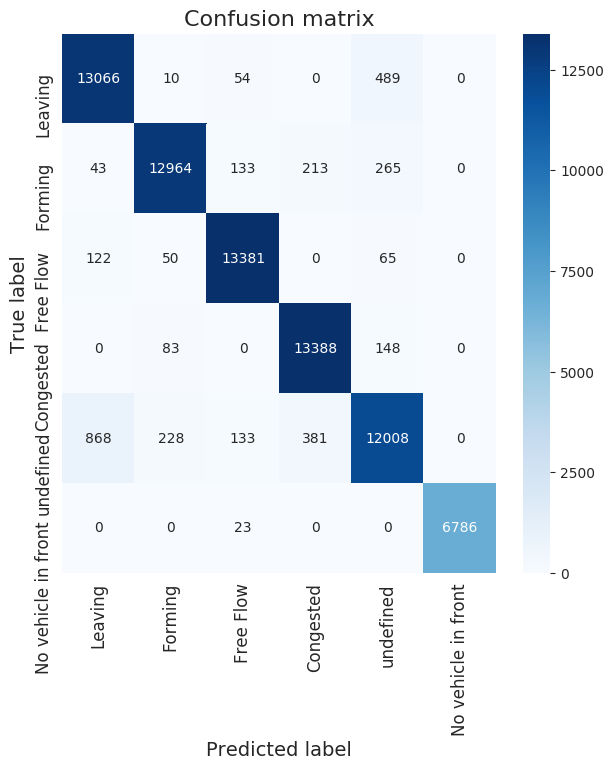

In [19]:
# Analyze: In the validation set what did the best model get wrong?
# Perform this on the test set

label_meanings = ["Leaving", "Forming", "Free Flow", "Congested", "undefined", "No vehicle in front"]

# Get confusion matrix 
y_test_pred = []
with torch.no_grad():
    for x in X_test:
        outputs = saved_best_net(torch.from_numpy(x).float().unsqueeze(0)) # Dataloader makes it float at training
        _, predicted_label = torch.max(outputs, 1)
        y_test_pred.append(predicted_label.numpy()[0])
y_test_pred = np.array(y_test_pred)

# Calculate accuracy on the test set
test_accuracy = np.mean(y_test_pred == y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

cm = confusion_matrix(y_test, y_test_pred)

fs = 16
fig, ax = plt.subplots(figsize=(7,7), dpi = 100)
ax.tick_params(axis='both', which='major', labelsize=fs-4)
sns.heatmap(cm, annot=True, fmt="d", 
            cmap='Blues', 
            xticklabels=label_meanings, 
            yticklabels=label_meanings)

ax.set_title('Confusion matrix', fontsize=fs)
ax.set_xlabel('Predicted label',fontsize=fs-2)
ax.set_ylabel('True label', fontsize=fs-2)
plt.show()